In [1]:
import os 
import torch 
import fnmatch
from torch import nn
from PIL import Image
from torchvision import transforms 
from tqdm.auto import tqdm 
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader 
import matplotlib.pyplot as plt 

C:\Users\Sania\gans-data-augmentation\gans_data_aug\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATA_PATHS = {
    "dataset": "./dataset/"
}

In [3]:
class PetrolPumpDataset(Dataset): 
    def __init__(self, img_dir, transform=None, extensions=['*.jpg', '*.jpeg', '*.png']):
        self.extensions = extensions 
        self.img_dir = img_dir
        self.image_paths = [f"{img_dir}/{img}" for img in os.listdir(img_dir) if any(fnmatch.fnmatch(img, ext) for ext in extensions)]
        self.transform = transform 
        
    def __len__(self): 
        return len(self.image_paths)
    
    def __getitem__(self, idx): 
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform: 
            image = self.transform(image)
            
        return image

In [4]:
dataset = PetrolPumpDataset(DATA_PATHS["dataset"], transform=transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])
]))

In [5]:
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
img = next(iter(dataloader))
img[0].shape

torch.Size([3, 256, 256])

In [6]:
def show_tensor_images(image_tensor, num_images=1):
    image_tensor = image_tensor.detach().cpu()
    image_tensor = image_tensor.permute(1, 2, 0)

    # Handling normalization 
    image_tensor = torch.clamp(image_tensor, min=0, max=1)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(image_tensor)
    plt.axis('off')
    plt.show()


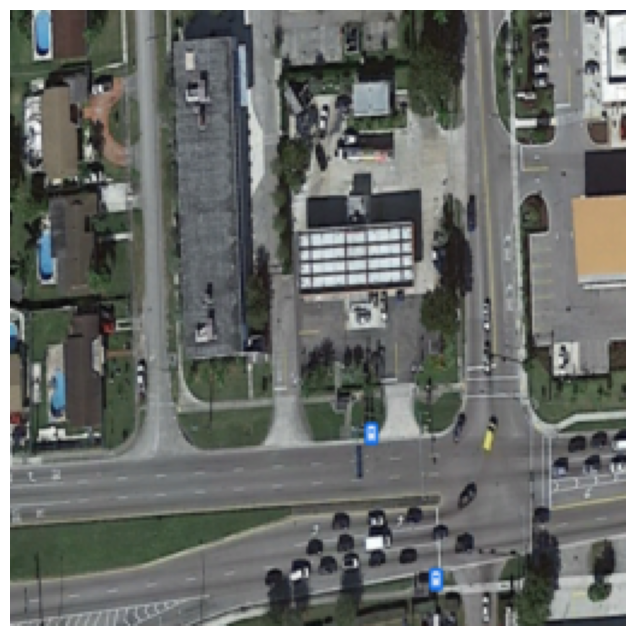

In [7]:
show_tensor_images(img[10])

In [17]:
class Generator(nn.Module):
    def __init__(self, z_dim=10, input_dim=3*256*256, hidden_dim=128):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            self._generator_block(z_dim, hidden_dim),
            self._generator_block(hidden_dim, hidden_dim * 2),
            self._generator_block(hidden_dim * 2, hidden_dim * 4),
            self._generator_block(hidden_dim * 4, hidden_dim * 8),
            nn.Linear(hidden_dim * 8, input_dim),
            nn.Sigmoid()
        )
        
    @staticmethod
    def _generator_block(input_dim, output_dim): 
        return nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.BatchNorm1d(output_dim), 
            nn.ReLU(inplace=True)
        )
        
    def forward(self, noise):
        return self.gen(noise)
    
    def get_gen(self):
        return self.gen

In [9]:
def get_noise(n_samples, z_dim): 
    return torch.randn(n_samples, z_dim)

In [19]:
class Discriminator(nn.Module):
    def __init__(self, input_dim=3*256*256, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self._discriminator_block(input_dim, hidden_dim * 4),
            self._discriminator_block(hidden_dim * 4, hidden_dim * 2),
            self._discriminator_block(hidden_dim * 2, hidden_dim),
            nn.Linear(hidden_dim, 1)
        )
        
    @staticmethod
    def _discriminator_block(input_dim, output_dim):
        return nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, image):
        return self.disc(image)
    
    def get_disc(self):
        return self.disc

In [32]:
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim):
    # Computing losses over fake samples 
    noise = get_noise(num_images, z_dim) 
    fake_images = gen(noise)
    disc_fake_pred = disc(fake_images.detach()) #Detaching the generator 
    disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
    
    # Computing losses over real samples 
    disc_real_pred = disc(real)
    disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
    
    return (disc_fake_loss + disc_real_loss)/2

In [33]:
def get_gen_loss(gen, disc, criterion, num_images, z_dim): 
    noise = get_noise(num_images, z_dim)
    fake_images = gen(noise)
    disc_fake_pred = disc(fake_images)
    
    return criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))

In [44]:
criterion = nn.BCEWithLogitsLoss()
n_epochs = 200
z_dim = 64 
display_step = 500  
batch_size = 128 
lr = 0.00001

In [35]:
gen = Generator(z_dim)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)

disc = Discriminator()
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [40]:
def display_tensor_images(image_tensor, num_images=25, size=(3, 256, 256)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    image_unflat = image_tensor.view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:37<00:00,  5.33s/it]


 43%|████████████████████████████████████                                                | 3/7 [00:16<00:22,  5.56s/it]

Step 14: Generator loss: 1.1992450313568113, discriminator loss: 0.5005190064311028


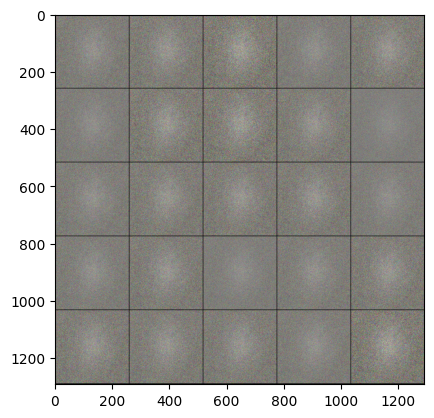

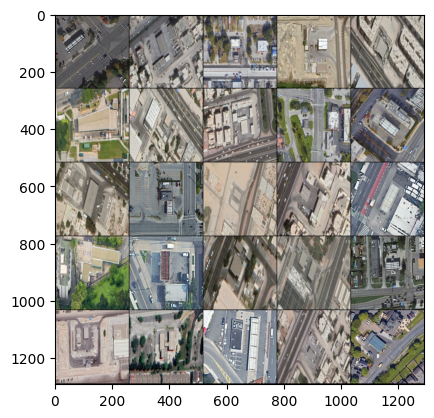

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:38<00:00,  5.46s/it]


 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [01:13<00:12, 12.29s/it]

Step 14: Generator loss: 1.9339513559937465, discriminator loss: 0.2951402473896739


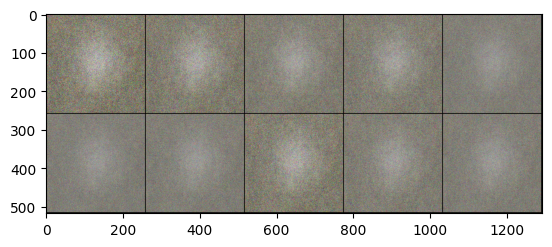

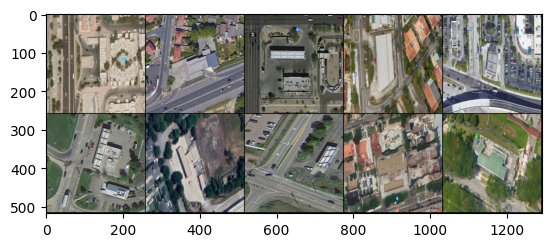

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:43<00:00,  6.14s/it]


In [45]:
current_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0

for epoch in range(n_epochs):
    for real in tqdm(dataloader):
        batch_size = len(real)
        real = real.view(batch_size, -1)

        disc_opt.zero_grad()
        disc_loss = get_disc_loss(gen, disc, criterion, real, batch_size, z_dim)
        disc_loss.backward(retain_graph=True)
        disc_opt.step()

        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, criterion, batch_size, z_dim)
        gen_loss.backward()
        gen_opt.step()

        mean_discriminator_loss += disc_loss.item() / display_step
        mean_generator_loss += gen_loss.item() / display_step

        if current_step % display_step == 0 and current_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            fake_noise = get_noise(batch_size, z_dim)
            fake = gen(fake_noise)
            display_tensor_images(fake)
            display_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        current_step += 1